In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra 
import selector as se

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = 1
eps_sublevel = 0.05
percent = 0.05

rho = 1 
res_type="primal"

num_resources = 10
num_agents = num_participants = 10

filename = "admm_resal_N%d_%.2f_n%d_m%d_%s"%(num_points, eps_sublevel, num_agents, num_resources, res_type)

In [4]:
num_resource_per_participant = 10
inner_size = 5

A_all, A_ineq, b_ineq = mra.resal_data(num_resources, num_participants, inner_size)

In [5]:
b_norm = 1

In [6]:
E, consensus2agent, agent2consensus, E_g = mra.resal_admm_matrices(num_agents, num_resources, A_ineq, A_all)
E_g = None

public_var_size = len(consensus2agent)
private_var_size = sum([agent2consensus[i].size for i in range(num_agents + 1)])
print(f"{public_var_size=}, {private_var_size=}")

public_var_size=100, private_var_size=200


# CVXPY centralized solution

In [7]:
true_x, true_f, true_lamb  = mra.centralized_solution_resal_admm(A_all, E, A_ineq, b_ineq, E_g)
print(f"{true_f=}")

true_f=-19.457708729505523


In [8]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

2.0

In [9]:
true_x.shape, true_lamb.shape

((200, 1), (200, 1))

In [10]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_agents):
    fun_agents_eps += [lambda z_k, lamb_k, K, i=i: mra.prox_resal_query_eps_o(lamb_k, z_k, i, A_all, rho,
                                                                           eps_sublevel=eps_sublevel, num_points=K, E_g=E_g)]
    fun_agents_noisy_y += [lambda z_k, lamb_k, K, i=i: mra.prox_resal_query_noisy_price_percent(lamb_k, z_k, i, A_all, rho,
                                                                        percent=percent, num_points=K, E_g=E_g)]
    
fun_agents_eps += [lambda z_k, lamb_k, K, i=i: mra.prox_resal_g_query_eps_o(lamb_k, z_k, A_ineq, b_ineq, E_g, rho, 
                                                                           eps_sublevel=eps_sublevel, num_points=K)]
fun_agents_noisy_y += [lambda z_k, lamb_k, K, i=i: mra.prox_resal_g_query_noisy_price_percent(lamb_k, z_k, A_ineq, b_ineq, E_g, rho,
                                                                        percent=percent, num_points=K)]

fun_obj_val = lambda x_k: mra.resal_obj_value(x_k, A_all, normalized=E_g is not None)

# ADMM

In [11]:
K_i = num_points

In [12]:
all_results_eps, lamb_k_eps, x_k, _, mra_xk_eps  = mra.admm_consensus(fun_agents_eps, fun_obj_val, agent2consensus, consensus2agent, E, 
                                                            rho=rho, postprocessing=1, K_i=K_i, num_iters=5000, 
                                                            true_f=true_f, print_freq=100, eps_res=1e-8,
                                                            res_type=res_type, history=1)


all_results_noisy_y, lamb_k_eps, x_k, _, mra_xk_noisy_y  = mra.admm_consensus(fun_agents_noisy_y, fun_obj_val, 
                                                            agent2consensus, consensus2agent, E, 
                                                            rho=rho, postprocessing=1, K_i=K_i, num_iters=10, 
                                                            true_f=true_f, print_freq=100, eps_res=1e-8,
                                                            res_type=res_type, history=1)

epoch=0, f_subopt_xk=7.0728E-01,  f_subopt_mra=7.0728E-01,  viol_prim_xk=7.0700E-01,  viol_prim_mra=7.0700E-01, rel_res=1.7073E+00, 0.0000E+00
epoch=100, f_subopt_xk=1.5356E-02,  f_subopt_mra=1.5356E-02,  viol_prim_xk=1.8482E-04,  viol_prim_mra=1.8482E-04, rel_res=5.4501E-03, 0.0000E+00
epoch=200, f_subopt_xk=9.9144E-03,  f_subopt_mra=9.9144E-03,  viol_prim_xk=4.0027E-05,  viol_prim_mra=4.0027E-05, rel_res=3.6158E-03, 0.0000E+00
epoch=300, f_subopt_xk=6.2448E-03,  f_subopt_mra=6.2448E-03,  viol_prim_xk=1.3373E-04,  viol_prim_mra=1.3373E-04, rel_res=2.8337E-03, 0.0000E+00
epoch=400, f_subopt_xk=4.2142E-03,  f_subopt_mra=4.2142E-03,  viol_prim_xk=9.4849E-06,  viol_prim_mra=9.4849E-06, rel_res=2.2150E-03, 0.0000E+00
epoch=500, f_subopt_xk=2.9363E-03,  f_subopt_mra=2.9363E-03,  viol_prim_xk=3.6455E-06,  viol_prim_mra=3.6455E-06, rel_res=1.7931E-03, 0.0000E+00
epoch=600, f_subopt_xk=2.0603E-03,  f_subopt_mra=2.0603E-03,  viol_prim_xk=8.5107E-07,  viol_prim_mra=8.5107E-07, rel_res=1.2860E-03

/Users/tepars/anaconda3/envs/py311/lib/python3.11/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


epoch=9, f_subopt_xk=5.1381E-03,  f_subopt_mra=5.1381E-03,  viol_prim_xk=2.6737E-02,  viol_prim_mra=2.6737E-02, rel_res=5.2188E-02, 0.0000E+00


In [13]:
if len(all_results_noisy_y["subopt_xk"]) > len(all_results_eps["subopt_xk"]):
    all_res = all_results_noisy_y
else:
    all_res = all_results_eps

In [14]:
T = 5000

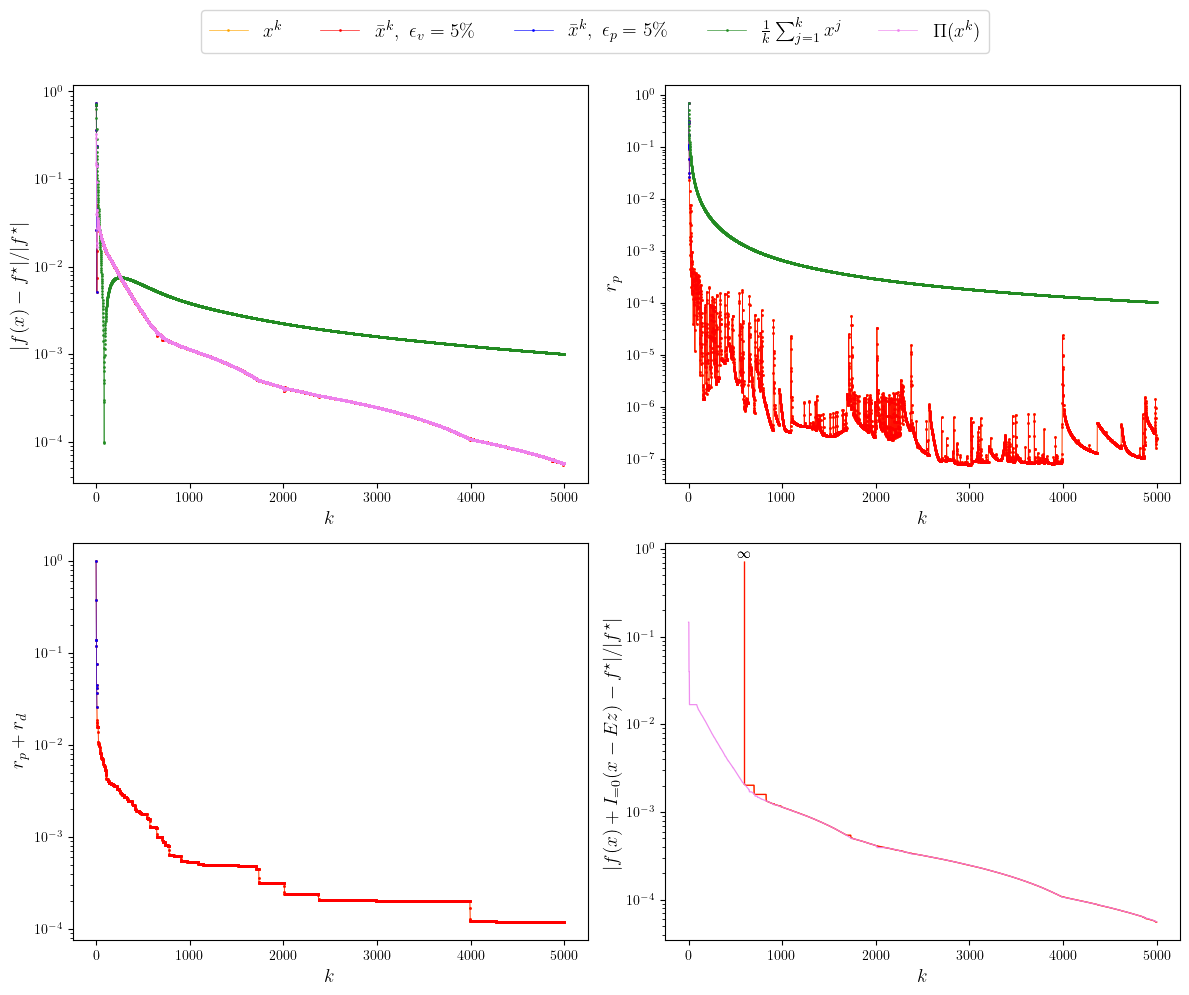

In [15]:
mra.plot_all_methods_metrics_4x(all_results_eps, all_results_noisy_y, true_f, 
                                b_norm, percent, eps_sublevel, None, T, admm=True)